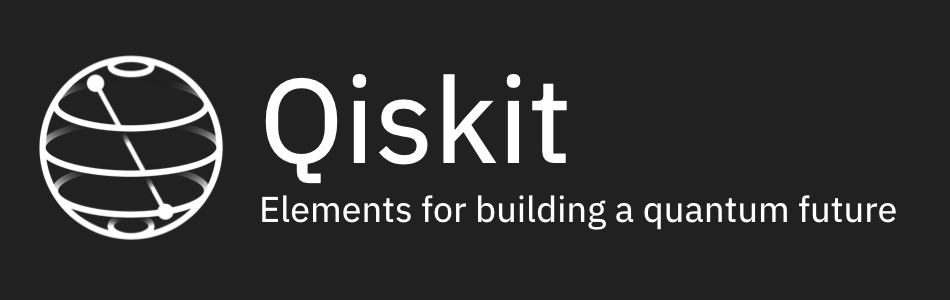

# Calibrating a qubit

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pprint as pp

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

### Loading a pulse backend
To run an OpenPulse experiment, at first we need to load a backend object of your quantum computing system with `open_pulse = True`. Then you will be able to program a `pulse` experiment using the pulse module. For more information on how to use the `pulse` module see this [tutorial](../terra/5_pulse_schedules.ipynb).

In this example we use `ibmq_armonk`, a one qubit system publicly available on the IBM Q Experience.

In [4]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(
    hub='ibm-q',
    group='open',
    project='main'
)
backend = ibmq_provider.get_backend('ibmq_armonk')

Credentials are already in use. The existing account in the session will be replaced.


In [5]:
config = backend.configuration()
defaults = backend.defaults()

### Creating our pulses

User defined pulses can be created from the standard pulse library found in `pulse_lib`, and able to find calibrated pulses provided by the backend in `defaults.circuit_instruction_map`. In this notebook, we use a Gaussian pulse template from `pulse_lib.gaussian` and default measurement pulses from the `circuit_instruction_map`

In [6]:
circ_inst_map = defaults.circuit_instruction_map

measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

In [7]:
# auto-phase the output measurement signal

def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

In this notebook, we apply the backend default setting for drive and measurement pulse frequency. These frequencies are calibrated to be centered at resonanse frequency of corresponding qubit and readout resonator. To change this setting, you can refer to the [qiskit community tutorials](https://github.com/Qiskit/qiskit-community-tutorials).

## Running a Rabi experiment

In this experiment, we apply a Rabi drive pulse to qubit0 and measure a signal from the qubit by changing the amplitude of the pulse (`drive_amps`) from 0 to 0.05. The returned signal is integrated and averaged over 512 shot.

In [8]:
# qubit to use for exeperiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 2048
drive_sigma = 256

# scaling factor for data returned by backend
# note: You may have to adjust this for the backend you use
scale_factor=1e-10

Pulse commands are registered to `Schedule`s with information of `channel` and the timestep they occur at. You can create your `Schedule` by using schedule composition methods or their syntactic sugar as shown below:  

- `|` (`union`): combine two `Schedule`s in parallel.
- `+` (`append`): add a `Schedule` right after a `Schedule` to be appended.
- `<<` (`shift`): shift `start_time` of `Schedule`.

Once create, `Schedule`s can be combined to form a composite `Schedule`. More details are available in this [tutorial](../terra/5_pulse_schedules.ipynb).

In [9]:
# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(pulse.DriveChannel(qubit))
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

We may plot any of the experiment schedules with:

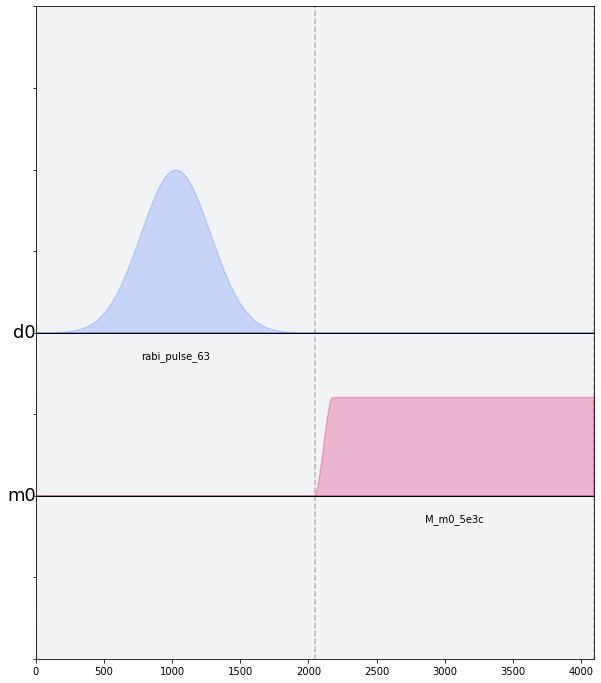

In [10]:
schedules[-1].draw(channels=[pulse.DriveChannel(qubit), pulse.MeasureChannel(qubit)],
                   label=True, plot_range=(0, 4096))

After `Schedule`s are now build for the Rabi experiment. We now assemble the Qobj to be sent to the quantum computing system. We use `meas_level=MeasLevel.KERNELED` (otherwise known as measurement level `meas_level=1`)  to get the default kernel integrated results from the system, and we automatically average them with `meas_return=MeasReturnType.AVERAGE` (otherwise known as `meas_return='avg'`).

In [11]:
rabi_qobj = assemble(schedules, backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

/home/daniel/anaconda3/envs/QiskitStandard/lib/python3.6/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


After building our rabi experiment Qobj we now submit it to the backend to be run.

In [12]:
job = backend.run(rabi_qobj)

We receive a job object for our experiment which we may be used to monitor and get the results of the experiment.

In [13]:
job.job_id()

'5e1c4a5a97290b0018034d57'

In [36]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

We now ask for the result from the quantum computing system, which will block until completion (or timeout).

In [37]:
rabi_result = job.result(timeout=3600)

### Analyze the result

The result for our experiment is stored in `pulse.MemorySlot(qubit)`. Looking at the signal amplitude, we will observe an oscillation of the signal as a function of the drive amplitude. This is known as a Rabi oscillation and corresponds to the qubit being periodically driven to its excited state and back again.

Below we extract the data from the returned system `memory`. 

In [38]:
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor

We now plot and fit the extracted signal to a sinusoid.

Pi Amplitude -0.010302


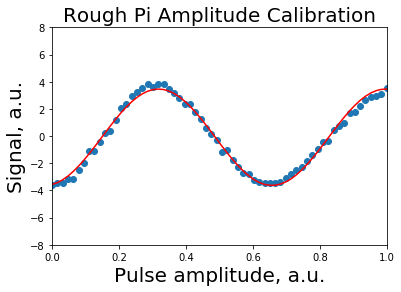

In [39]:
rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,1.0,0])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

From the fit we obtain the Rabi oscillation frequency. We may use this to extract the amplitude of a $\pi$ pulse. This is the required amplitude to drive the qubit from the ground state ($|0\rangle$) to the excited state ($|1\rangle$).

## The QObj

The experiment is specified in the `rabi_qobj`, an instance of `PulseQobj`.

> backend.run(rabi_qobj)

The backend must thus be able to parse the `PulseQobj` object. It contains many elements, such as readout and qubit frequencies.

In [51]:
print(rabi_qobj.config.meas_lo_freq)
print(rabi_qobj.config.qubit_lo_freq)

[6.993427855]
[4.974289865312971]


 The pulse shapes are defined in the QObj as sample pulses and/or parametric pulses (comming in future releases). The example below shows a sample pulse.

In [52]:
print(rabi_qobj.config.pulse_library[10])

PulseLibraryItem(name='rabi_pulse_9', samples=array([3.75900549e-07+0.j, 1.13600564e-06+0.j, 1.90730826e-06+0.j, ...,
       1.90730826e-06+0.j, 1.13600564e-06+0.j, 3.75900549e-07+0.j]))


The QObj also contains the experiments to run, specified as a list. Each element contains a header and a list of instructions.

In [53]:
pp.pprint(rabi_qobj.experiments[4].to_dict())

{'header': {'memory_slots': 1,
            'name': 'Rabi Experiment at drive amp = 0.06349206349206349'},
 'instructions': [{'ch': 'd0', 'name': 'rabi_pulse_4', 't0': 0},
                  {'duration': 16000,
                   'memory_slot': [0],
                   'name': 'acquire',
                   'qubits': [0],
                   't0': 2048},
                  {'ch': 'm0', 'name': 'M_m0_5e3c', 't0': 2048}]}


The backend must therefore be able to parse all the elements in the Qobj. Note that many elements in the Qobj come from the default values of the device, such as qubit LO frequencies. These values are obtained from the backend through

```
defaults = backend.defaults()
```

Additional information on the backend is also found in the configutation, obtained through
```
config = backend.configuration()
```
The configuration holds information such as the sample length.

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright